In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, max_error, explained_variance_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.tree import DecisionTreeRegressor

INPUT_FILE = "dataset/books.csv"

np.random.seed(42)


In [2]:
# Encoding determined by opening file in a text editor
with open(INPUT_FILE, "r", encoding='utf-8') as inputFile:
    firstFiveLines = [next(inputFile) for line in range(5)]
    fileLineCount = sum(1 for _ in inputFile) + 5
print(firstFiveLines)


['bookID,title,authors,average_rating,isbn,isbn13,language_code,  num_pages,ratings_count,text_reviews_count,publication_date,publisher\n', '1,Harry Potter and the Half-Blood Prince (Harry Potter  #6),J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.\n', '2,Harry Potter and the Order of the Phoenix (Harry Potter  #5),J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.\n', '4,Harry Potter and the Chamber of Secrets (Harry Potter  #2),J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic\n', '5,Harry Potter and the Prisoner of Azkaban (Harry Potter  #3),J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.\n']


In [3]:
rawDF = pd.read_csv(INPUT_FILE, sep=",", index_col="bookID",
                    on_bad_lines="skip", encoding="utf-8")
print(rawDF.head())


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating        isbn         isbn13  \
bookID                                                                          
1       J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
4                     J.K. Rowling            4.42  0439554896  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

    

In [4]:
print(f"Raw file line count (excluding header): {str(fileLineCount-1)}")
print(f"Imported Dataframe shape: {str(rawDF.shape)}")


Raw file line count (excluding header): 11127
Imported Dataframe shape: (11123, 11)


In [5]:
print(rawDF.dtypes)


title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object


In [6]:
# dropping "isbn" column as "isbn13" better conveys the same information
df = rawDF.drop(columns=["isbn"])


In [7]:
# typical null check returns no nulls, but needs further checks for "object" columns
print(df.isna().sum())


title                 0
authors               0
average_rating        0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


In [8]:
objectColumns = df.select_dtypes(include=["object"]).columns
for column in objectColumns:
    print(f"{column}: {sum(df[column].values == '')}")

# # %%
# # explore potentially categorical values

# # %%
# print(df.loc[df.language_code.str.contains("-")].language_code.value_counts())


title: 0
authors: 0
language_code: 0
publication_date: 0
publisher: 0


In [9]:
print(df.loc[
        df.ratings_count == 0,
        ["average_rating"]
    ].value_counts())


average_rating
0.00              25
4.00               3
5.00               3
2.83               2
4.03               2
4.06               2
3.50               2
3.58               2
4.33               2
3.80               2
4.14               2
4.17               1
4.05               1
4.11               1
4.13               1
2.98               1
4.19               1
3.98               1
4.24               1
4.39               1
4.43               1
4.44               1
4.50               1
4.78               1
4.20               1
3.88               1
3.91               1
3.11               1
3.29               1
3.33               1
3.44               1
3.54               1
3.57               1
3.60               1
3.64               1
3.67               1
3.70               1
3.75               1
3.78               1
3.81               1
3.82               1
3.83               1
2.00               1
3.85               1
dtype: int64


In [10]:
print(df.loc[(df.average_rating == 0) & (df.ratings_count != 0)])


Empty DataFrame
Columns: [title, authors, average_rating, isbn13, language_code,   num_pages, ratings_count, text_reviews_count, publication_date, publisher]
Index: []


In [11]:
# removing rows with 0 average ratings (and missing ratings count)
df = df.loc[df.average_rating != 0]
print(df.shape)


(11098, 10)


In [12]:
print(df.loc[
        df.ratings_count == 0,
        ["average_rating"]
    ].value_counts().head())


average_rating
5.00              3
4.00              3
4.14              2
2.83              2
4.03              2
dtype: int64


In [13]:
# replace missing rating counts with the median
median_ratings_count = df.ratings_count.median()
df.ratings_count = df.ratings_count.map(lambda x: median_ratings_count if x == 0 else x)
print(df.ratings_count.value_counts())


3.0         82
1.0         76
2.0         71
4.0         71
5.0         61
            ..
21507.0      1
6970.0       1
108440.0     1
66503.0      1
783.0        1
Name: ratings_count, Length: 5294, dtype: int64


In [14]:
# check numerical features for outliers
df["num_pages"] = df["  num_pages"]
df.drop("  num_pages", axis=1, inplace=True)


<AxesSubplot:>

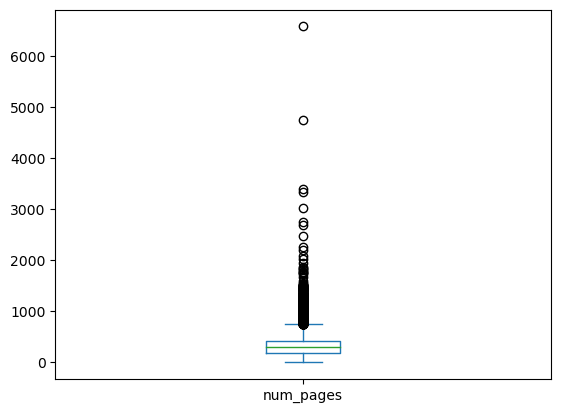

In [15]:
df.num_pages.plot.box()


0.01      3.0
0.95    752.0
Name: num_pages, dtype: float64
(297, 10)


<AxesSubplot:>

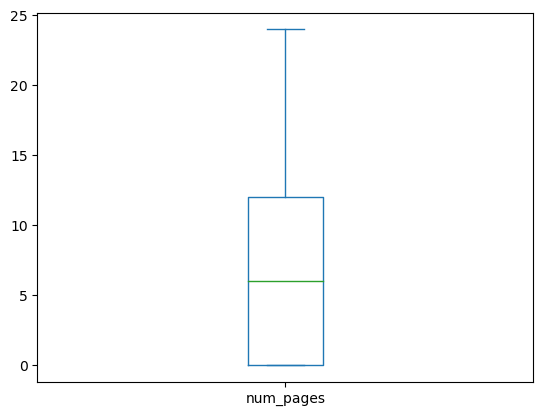

In [16]:
print(df.num_pages.quantile(q=[0.01, 0.95]))
print(df.loc[df["num_pages"] < 25].shape)
# exploring low page counts
df.loc[df["num_pages"] < 25].num_pages.plot.box()

# # %%
# # removing books with num_pages < 25
# df = df[df["num_pages"] > 25]
# print(df.shape)

# # %%
# # checking books with high page count (95th percentile rounded to nearest tenth)
# print(df.loc[df["num_pages"] > 750].shape)
# # exploring low page counts
# df.loc[df["num_pages"] > 750].num_pages.plot.box()

# # %%
# # despite the high count and range, removing the top 5% num_pages
# df = df[df["num_pages"] <= 750]
# print(df.shape)
# df.num_pages.plot.box()


In [17]:
# convert publication_date to date dtype and extract features
# df["processed_date"] = pd.to_datetime(df["publication_date"])


In [18]:
# this fails the first time. checking and fixing the incorrect dates from the logs
df.loc[df["publication_date"] == "11/31/2000", "publication_date"] = "11/30/2000"
df.loc[df["publication_date"] == "6/31/1982", "publication_date"] = "6/30/1982"


In [19]:
# retrying the above
df["processed_date"] = pd.to_datetime(df["publication_date"])
print(df.head())


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count publication_date  \
bookID      

In [20]:
# extracting year and month of publication and dropping the original feature
df["publication_year"] = df["processed_date"].dt.year
df["publication_month"] = df["processed_date"].dt.month
df.drop(["processed_date", "publication_date"], axis=1, inplace=True)
print(df.head())


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID      

In [21]:
# fixing ratings_count's dtype
df["ratings_count"] = df["ratings_count"].astype(int)
print(df.head())


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID      

In [22]:
# extract features from title
# removing extra parts from title (e.g. the sub-title after colon or brackets)
def get_main_title(title):
    main_title = title.split(":")
    main_title = main_title[0]
    main_title = main_title.split("(")
    main_title = main_title[0]
    return main_title

df["main_title"] = df.title.apply(get_main_title)
print(df.loc[:, ["title", "main_title"]])


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   
...                                                   ...   
45631    Expelled from Eden: A William T. Vollmann Reader   
45633                         You Bright and Risen Angels   
45634                     The Ice-Shirt (Seven Dreams #1)   
45639                                         Poor People   
45641                         Las aventuras de Tom Sawyer   

                                        main_title  
bookID                                              
1          Harry Potter and the Half-Blood Prince   
2       Harry Potter and the Order of the Phoen

In [23]:
# get (main) title length and word count
df["title_length"] = df["main_title"].str.len()
df["title_word_count"] = df["main_title"].apply(lambda x: len(x.split()))
print(df.head())


                                                    title  \
bookID                                                      
1       Harry Potter and the Half-Blood Prince (Harry ...   
2       Harry Potter and the Order of the Phoenix (Har...   
4       Harry Potter and the Chamber of Secrets (Harry...   
5       Harry Potter and the Prisoner of Azkaban (Harr...   
8       Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID      

In [24]:
# drop title (and main_title)
df.drop(["title"], axis=1, inplace=True) #df.drop(["main_title", "title"], axis=1, inplace=True)
print(df.head())


                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID                                                                     
1                eng        2095690               27591  Scholastic Inc.   
2                eng        2153167               29221  Scholastic Inc.   
4                eng           6333                 244       Scholastic   
5                eng        2339585               36325  Scholastic Inc.   
8                eng          41428                 164     

In [25]:
# extract features from authors
# extract total author count and the first author name
def get_author_count(authors):
    author_count = authors.split("/")
    author_count = len(author_count)
    return author_count

def get_main_author(authors):
    main_author = authors.split("/")
    main_author = main_author[0]
    return main_author


In [26]:
df["author_count"] = df.authors.apply(get_author_count)
df["main_author"] = df.authors.apply(get_main_author)
print(df.head())


                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID                                                                     
1                eng        2095690               27591  Scholastic Inc.   
2                eng        2153167               29221  Scholastic Inc.   
4                eng           6333                 244       Scholastic   
5                eng        2339585               36325  Scholastic Inc.   
8                eng          41428                 164     

In [27]:
# get main author's name length and word "count"
df["main_author_name_length"] = df["main_author"].str.len()
df["main_author_name_word_count"] = df["main_author"].apply(lambda x: len(x.split()))
df["main_author_short_name_count"] = df["main_author"].str.count("\.")
print(df.head())


                           authors  average_rating         isbn13  \
bookID                                                              
1       J.K. Rowling/Mary GrandPré            4.57  9780439785969   
2       J.K. Rowling/Mary GrandPré            4.49  9780439358071   
4                     J.K. Rowling            4.42  9780439554893   
5       J.K. Rowling/Mary GrandPré            4.56  9780439655484   
8       J.K. Rowling/Mary GrandPré            4.78  9780439682589   

       language_code  ratings_count  text_reviews_count        publisher  \
bookID                                                                     
1                eng        2095690               27591  Scholastic Inc.   
2                eng        2153167               29221  Scholastic Inc.   
4                eng           6333                 244       Scholastic   
5                eng        2339585               36325  Scholastic Inc.   
8                eng          41428                 164     

In [28]:
# fix 0-page books to prevent calculation issues
df["num_pages"] = df.num_pages.apply(lambda x: 1 if x == 0 else x)
# generate features using existing numerical ones
df["text_reviews_ratio"] = df["text_reviews_count"] / df["ratings_count"]
df["text_reviews_count_per_page"] = df["text_reviews_count"] / df["num_pages"]
df["ratings_count_per_page"] = df["ratings_count"] / df["num_pages"]
# artificial attributes that might help
df["ratings_count_times_text_reviews_count"] = df["text_reviews_count"] * df["ratings_count"]
df["text_reviews_count_times_num_pages"] = df["text_reviews_count"] * df["num_pages"]
df["ratings_count_times_num_pages"] = df["ratings_count"] * df["num_pages"]
df["ratings_count_times_text_reviews_count_times_num_pages"] = df["text_reviews_count"] * df["ratings_count"] * df["num_pages"]


In [29]:
# categorical label-level aggregation features

main_author_mean = df.groupby("main_author").mean()
main_author_count = df.groupby("main_author").count()
publisher_count = df.groupby("publisher").count()
publication_year_sum = df.groupby("publication_year").sum()
publication_month_sum = df.groupby("publication_month").sum()

df["english_book"] = df.language_code.apply(lambda x: 1 if x.startswith("eng") else 0)
df["main_author_book_count"] = df.main_author.apply(lambda x: main_author_count["isbn13"][x])
df["main_author_average_text_reviews_count"] = df.main_author.apply(lambda x: main_author_mean["ratings_count"][x])
df["main_author_average_text_reviews_count"] = df.main_author.apply(lambda x: main_author_mean["text_reviews_count"][x])
df["publisher_count"] = df.publisher.apply(lambda x: publisher_count["isbn13"][x])
df["publication_year_ratings_count"] = df.publication_year.apply(lambda x: publication_year_sum["ratings_count"][x])
df["publication_year_text_reviews_count"] = df.publication_year.apply(lambda x: publication_year_sum["text_reviews_count"][x])
df["publication_month_ratings_count"] = df.publication_month.apply(lambda x: publication_month_sum["ratings_count"][x])
df["publication_month_text_reviews_count"] = df.publication_month.apply(lambda x: publication_month_sum["text_reviews_count"][x])


C:\Users\monOrdi\AppData\Local\Temp\ipykernel_7008\1176742598.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  main_author_mean = df.groupby("main_author").mean()
C:\Users\monOrdi\AppData\Local\Temp\ipykernel_7008\1176742598.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  publication_year_sum = df.groupby("publication_year").sum()
C:\Users\monOrdi\AppData\Local\Temp\ipykernel_7008\1176742598.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shoul

In [30]:
publisher_counts = df.publisher.value_counts()
print(publisher_counts)


Vintage                             318
Penguin Books                       261
Penguin Classics                    184
Mariner Books                       150
Ballantine Books                    144
                                   ... 
W.W. Norton & Company  Inc. (NY)      1
Pyramid Books                         1
Hyperio                               1
Jump at the Sun                       1
Faber & Faber Limited                 1
Name: publisher, Length: 2275, dtype: int64


In [31]:
small_publishers = publisher_counts.loc[(publisher_counts < 100)].index.values.tolist()
print(f"Out of {len(publisher_counts)} publishers, {len(small_publishers)} are \"small\".")


Out of 2275 publishers, 2266 are "small".


In [32]:
# replace small publishers with "other" value
df.publisher = df.publisher.map(lambda x: "other" if x in small_publishers else x)
# removing spaces to help with feature engineering later
df.publisher = df.publisher.map(lambda x: x.replace(" ", ""))
print(df.publisher.value_counts())


other              9596
Vintage             318
PenguinBooks        261
PenguinClassics     184
MarinerBooks        150
BallantineBooks     144
HarperPerennial     112
HarperCollins       112
PocketBooks         111
Bantam              110
Name: publisher, dtype: int64


In [33]:
language_code_counts = rawDF.language_code.value_counts()
print(language_code_counts)
rare_languages = language_code_counts.loc[
        (language_code_counts < 50) &
        ~(language_code_counts.index.str.contains("-"))
    ].index.values.tolist()
print(rare_languages)   # excluded eng-... variant, i.e. en-CA


eng      8908
en-US    1408
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64
['jpn', 'mul', 'zho', 'grc', 'por', 'ita', 'enm', 'lat', 'swe', 'rus', 'srp', 'nl', 'msa', 'glg', 'wel', 'ara', 'nor', 'tur', 'gla', 'ale']


In [34]:
# replace rare languages with "other" value
df.language_code = df.language_code.map(lambda x: "other" if x in rare_languages else x)
print(df.language_code.value_counts())


eng      8885
en-US    1408
spa       218
en-GB     214
fre       144
other     123
ger        99
en-CA       7
Name: language_code, dtype: int64


In [35]:
# drop authors and main_author
df.drop(["main_author", "authors"], axis=1, inplace=True)
# df.drop(["publisher", "language_code"], axis=1, inplace=True)
df.drop(["main_title"], axis=1, inplace=True)
print(df.head())


        average_rating         isbn13 language_code  ratings_count  \
bookID                                                               
1                 4.57  9780439785969           eng        2095690   
2                 4.49  9780439358071           eng        2153167   
4                 4.42  9780439554893           eng           6333   
5                 4.56  9780439655484           eng        2339585   
8                 4.78  9780439682589           eng          41428   

        text_reviews_count publisher  num_pages  publication_year  \
bookID                                                              
1                    27591     other        652              2006   
2                    29221     other        870              2004   
4                      244     other        352              2003   
5                    36325     other        435              2004   
8                      164     other       2690              2004   

        publication_month

In [36]:
# feature selection
# one-hot encode categorical features
df = pd.get_dummies(df)
print(df.shape)
print(df.head(1))


(11098, 46)
        average_rating         isbn13  ratings_count  text_reviews_count  \
bookID                                                                     
1                 4.57  9780439785969        2095690               27591   

        num_pages  publication_year  publication_month  title_length  \
bookID                                                                 
1             652              2006                  9            39   

        title_word_count  author_count  ...  publisher_BallantineBooks  \
bookID                                  ...                              
1                      6             2  ...                          0   

        publisher_Bantam  publisher_HarperCollins  publisher_HarperPerennial  \
bookID                                                                         
1                      0                        0                          0   

        publisher_MarinerBooks  publisher_PenguinBooks  \
bookID              

In [37]:
# print correlation matrix for the current dataframe
correlation_to_target = df.corr()['average_rating'][1:]
print(correlation_to_target)


isbn13                                                   -0.000850
ratings_count                                             0.040397
text_reviews_count                                        0.033494
num_pages                                                 0.164328
publication_year                                         -0.046715
publication_month                                         0.026971
title_length                                              0.090500
title_word_count                                          0.078925
author_count                                              0.025522
main_author_name_length                                   0.009490
main_author_name_word_count                              -0.012296
main_author_short_name_count                              0.081567
text_reviews_ratio                                       -0.142165
text_reviews_count_per_page                               0.021166
ratings_count_per_page                                    0.03

In [38]:
# drop the features with |correlation| < 0.01
low_correlation = correlation_to_target[(correlation_to_target < 0.01) & (correlation_to_target > -0.01)]
df.drop(low_correlation.index.tolist(), axis=1, inplace=True)
print(df.head())


        average_rating  ratings_count  text_reviews_count  num_pages  \
bookID                                                                 
1                 4.57        2095690               27591        652   
2                 4.49        2153167               29221        870   
4                 4.42           6333                 244        352   
5                 4.56        2339585               36325        435   
8                 4.78          41428                 164       2690   

        publication_year  publication_month  title_length  title_word_count  \
bookID                                                                        
1                   2006                  9            39                 6   
2                   2004                  9            42                 8   
4                   2003                 11            40                 7   
5                   2004                  5            41                 7   
8                   2

In [39]:
# better correlation matrix to quickly visualize
def get_correlation_matrix_graph(correlation_matrix):
    data = np.array(correlation_matrix)
    fig = ff.create_annotated_heatmap(
        data,
        x = list(correlation_matrix.columns),
        y = list(correlation_matrix.index),
        annotation_text = np.around(data, decimals = 2),
        hoverinfo = "z",
        colorscale= "Viridis"
    )
    return fig

get_correlation_matrix_graph(df.corr())


In [40]:
# new synthetic features
df["mean_title_word_length"] = df["title_length"] / df["title_word_count"]
df["publisher_PenguinBooks_times_count"] = df["publisher_count"] * df["publisher_Vintage"]
df["publisher_Vintage_times_count"] = df["publisher_Vintage"] * df["publisher_count"]


In [42]:
# scatterplots of each feature with average_rating
def get_scatterplot_wrt_target(df, target_feature, feature):
    test = df[[feature, target_feature]].groupby([feature, target_feature]).value_counts().reset_index(name="count")
    px.scatter(data_frame=test, x=feature, y=target_feature, color="count").show()

def get_scatterplots_wrt_target_for_df(df, target_feature):
    for feature in df.columns:
        if feature != target_feature and feature in df.select_dtypes(include=[np.number]).columns:
            get_scatterplot_wrt_target(df, target_feature, feature)

get_scatterplots_wrt_target_for_df(df, "average_rating")


In [43]:
# functions to perform training and scoring in batch

def score_model(regressor, y_test, y_pred, X_test):
    print(f"mean absolute error:\t\t{mean_squared_error(y_true = y_test, y_pred = y_pred)}")
    print(f"max error:\t\t\t{max_error(y_true = y_test, y_pred = y_pred)}")
    print(f"r2 score:\t\t\t{regressor.score(X_test, y_test)}")
    print(f"explained variance score:\t{explained_variance_score(y_true = y_test, y_pred = y_pred)}")

def batch_regression_model_training(df, regressor_list, target_feature):
    y = df[target_feature]
    X = df.drop(target_feature, axis=1)

    # # normalize dataset
    # scaler = MinMaxScaler()
    # X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
    # # print(X.head())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Dataset split into {len(y_train)} train rows and {len(y_test)} test rows.")

    # batch training
    for regressor in regressor_list:
        print(regressor)
        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)
        score_model(regressor, y_test, y_pred, X_test)


In [44]:
# define the models to test
regressor_list = [RandomForestRegressor(random_state = 42), AdaBoostRegressor(random_state = 42),
    DecisionTreeRegressor(random_state = 42), LinearRegression(), DummyRegressor()
]


In [45]:
# run the training
batch_regression_model_training(df, regressor_list, "average_rating")


Dataset split into 8878 train rows and 2220 test rows.
RandomForestRegressor(random_state=42)
mean absolute error:		0.07973807452736362
max error:			3.0432000000000006
r2 score:			0.17106716459931937
explained variance score:	0.17180662038251715
AdaBoostRegressor(random_state=42)
mean absolute error:		0.11079623528048543
max error:			3.2317830609212708
r2 score:			-0.15180405354854898
explained variance score:	-0.007694912349559546
DecisionTreeRegressor(random_state=42)
mean absolute error:		0.15672405405405407
max error:			3.4000000000000004
r2 score:			-0.6292557259823754
explained variance score:	-0.6292429610692323
LinearRegression()
mean absolute error:		0.08926963799981642
max error:			2.8567121808268943
r2 score:			0.0719799220009234
explained variance score:	0.07273230783138107
DummyRegressor()
mean absolute error:		0.096209898755721
max error:			2.9421311106104984
r2 score:			-0.00016892359024778258
explained variance score:	1.1102230246251565e-16


In [46]:
# run on original dataset to sanity check
batch_regression_model_training(rawDF.select_dtypes(include=[np.number]), regressor_list, "average_rating")


Dataset split into 8898 train rows and 2225 test rows.
RandomForestRegressor(random_state=42)
mean absolute error:		0.10922789786671049
max error:			3.4253
r2 score:			0.1342523386830129
explained variance score:	0.13437067973203976
AdaBoostRegressor(random_state=42)
mean absolute error:		0.11312568559983373
max error:			3.1295461783439475
r2 score:			0.10335821108221122
explained variance score:	0.10904302963425205
DecisionTreeRegressor(random_state=42)
mean absolute error:		0.2110444382022472
max error:			4.44
r2 score:			-0.6727524046147373
explained variance score:	-0.6725506746464771
LinearRegression()
mean absolute error:		0.1228780423004273
max error:			3.924517349169691
r2 score:			0.026060376272912467
explained variance score:	0.02621325965996213
DummyRegressor()
mean absolute error:		0.1261913021739487
max error:			3.9350820409080693
r2 score:			-0.00020074421790639008
explained variance score:	0.0


In [47]:
# Hyperparameter of RandomForestRegressor
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 19)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2, 3, 4]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 20, num = 17)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 13)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(2, 20, num = 9)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [48]:
rf_tuner = RandomizedSearchCV(estimator = regressor_list[0],
    param_distributions=random_grid, n_iter=100, cv=2,
    scoring="r2", return_train_score=True,
    verbose=2, random_state=42, n_jobs=-1)

y = df["average_rating"]
X = df.drop("average_rating", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# rf_tuner.fit(X_train, y_train)

# print(rf_tuner.best_params_)

# # %%
# tuned_rf = rf_tuner.best_estimator_
# y_pred = tuned_rf.predict(X_test)
# score_model(tuned_rf, y_test, y_pred, X_test)


In [49]:
# sanity check with the "stock" model
stock_rf = regressor_list[0]
stock_rf.fit(X_train, y_train)
y_pred = stock_rf.predict(X_test)
score_model(stock_rf, y_test, y_pred, X_test)


mean absolute error:		0.07973807452736362
max error:			3.0432000000000006
r2 score:			0.17106716459931937
explained variance score:	0.17180662038251715


In [50]:
# compare prediction by reducing precision
def scores_with_varying_precision(y_pred, y_test):
    # baseline
    print(f"baseline\t{np.sum(y_pred == y_test)}\t{round(np.sum(y_pred == y_test)*100/len(y_pred), 1)}%")

    # to nearest tenth
    y_test_tenth = np.array([round(x, 1) for x in y_test])
    y_pred_tenth = np.array([round(x, 1) for x in y_pred])
    print(f"tenth\t\t{np.sum(y_pred_tenth == y_test_tenth)}\t{round(np.sum(y_pred_tenth == y_test_tenth)*100/len(y_pred_tenth), 1)}%")

    # dummy predict top two values (integers)
    y_test_whole = np.array([round(x) for x in y_test])
    y_pred_dummy = np.random.randint(3, 5, len(y_test))
    print(f"dummy\t\t{np.sum(y_test_whole == y_pred_dummy)}\t{round(np.sum(y_test_whole == y_pred_dummy)*100/len(y_pred_dummy),1)}%")

    # to nearest half
    y_test_half = np.array([round(x * 2) / 2 for x in y_test])
    y_pred_half = np.array([round(x * 2) / 2 for x in y_pred])
    print(f"half\t\t{np.sum(y_test_half == y_pred_half)}\t{round(np.sum(y_test_half == y_pred_half)*100/len(y_pred_half), 1)}%")

    # to nearest number
    y_pred_whole = np.array([round(x) for x in y_pred])
    print(f"number\t\t{np.sum(y_test_whole == y_pred_whole)}\t{round(np.sum(y_test_whole == y_pred_whole)*100/len(y_pred_whole),1)}%")

scores_with_varying_precision(y_pred, y_test)


baseline	0	0.0%
tenth		409	18.4%
dummy		1068	48.1%
half		1486	66.9%
number		2025	91.2%


In [51]:
# scores prediction visually
# baseline
px.scatter(x=y_test, y=y_pred, range_x=[0,5.1], range_y=[0,5.1], labels={'x':'real', 'y':'predicted'}, trendline="ols").show()


In [52]:
# whole numbers
y_test_whole = np.array([round(x) for x in y_test])
y_pred_whole = np.array([round(x) for x in y_pred])
px.scatter(x=y_test_whole, y=y_pred_whole, range_x=[0,5.1], range_y=[0,5.1], labels={'x':'real', 'y':'predicted'}).show()


In [53]:
# getting an idea of imabalance between the target values
print(df.average_rating.value_counts().value_counts())


1      26
2      12
4       8
8       8
5       7
       ..
133     1
43      1
134     1
40      1
219     1
Name: average_rating, Length: 94, dtype: int64


In [54]:
# # Undersampling -> SMOTE
# undersampler = RandomUnderSampler(sampling_strategy={4:5000}, random_state=42)
# oversampler = SMOTE(sampling_strategy={2:200, 5:250}, random_state=42)

# y_whole = np.array([round(x) for x in y])

# X_bal, y_bal = undersampler.fit_resample(X, y_whole)
# X_bal, y_bal = oversampler.fit_resample(X_bal, y_bal)

# # %%
# # test with stock random forest
# stock_rf = regressor_list[0]
# X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
# stock_rf.fit(X_train, y_train)
# y_pred = stock_rf.predict(X_test)
# score_model(stock_rf, y_test, y_pred, X_test)


In [55]:
# mapping target variable to non-linear functions
y_sqrt = df.average_rating.map(lambda y: np.sqrt(y))
y_log_10 = df.average_rating.map(lambda y: np.log10(y))
y_log_2 = df.average_rating.map(lambda y: np.log2(y))
y_log_e = df.average_rating.map(lambda y: np.log(y))
#y_bc, lambda_bc = stats.boxcox(y)
box_cox_transformer = PowerTransformer(method="box-cox")
y_bc = box_cox_transformer.fit_transform(df.average_rating.array.reshape(-1, 1)).ravel()
y_mapped = [y_bc] # [y_sqrt, y_log_10, y_log_2, y_log_e]


In [56]:
# test performance
for y in y_mapped:
    stock_rf = regressor_list[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    stock_rf.fit(X_train, y_train)
    y_pred = stock_rf.predict(X_test)
    score_model(stock_rf, y_test, y_pred, X_test)
    scores_with_varying_precision(y_pred, y_test)
    px.scatter(x=y_test, y=y_pred, range_x=[min(min(y_test), min(y_pred)),1.1*max(max(y_test), max(y_pred))], range_y=[min(min(y_test), min(y_pred)),1.1*max(max(y_test), max(y_pred))], labels={'x':'real', 'y':'predicted'}).show()


mean absolute error:		0.856387687242016
max error:			6.230012364678958
r2 score:			0.1930358108047795
explained variance score:	0.19352263977032502
baseline	0	0.0%
tenth		111	5.0%
dummy		7	0.3%
half		539	24.3%
number		1005	45.3%


In [57]:
# sanity check by running transformation on original datset
stock_rf = regressor_list[0]
X_raw = rawDF.drop("average_rating", axis=1).select_dtypes(include=[np.number])
y_raw_bc = box_cox_transformer.fit_transform(rawDF.average_rating.map(lambda x: 0.01 if x == 0 else x).array.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw_bc, test_size=0.2, random_state=42)
stock_rf.fit(X_train, y_train)
y_pred = stock_rf.predict(X_test)
score_model(stock_rf, y_test, y_pred, X_test)


mean absolute error:		0.8958481346043193
max error:			6.831217796311822
r2 score:			0.08698814481990924
explained variance score:	0.08700741871949891
